# Insight Teams Connectivity
## Definitions
Nodes: (369 nodes) Each node represents a different station in the London train network (see further classifications below)\
Edges: (441 edges) Each edge represents a connection between one station to another\
Layers: (1-3) Each node is assigned to a corresponding layer of the train network
1. Underground (The Tube)
2. Overground
3. DLR (Docklands Light Railway, automated light metro system)

Undirected: It is possible to travel back and forth between two stations\
Weights: (1-3) Represent the number of different lines connecting two stations (applies to only Underground)


## Citations
Original Dataset: https://networks.skewed.de/net/london_transport\
Paper: De Domenico, Manlio, et al. “Navigability of Interconnected Networks under Random Failures.” Proceedings of the National Academy of Sciences, vol. 111, no. 23, June 2014, pp. 8351–56. DOI.org (Crossref), https://doi.org/10.1073/pnas.1318469111.


In [264]:
#Importing packages
import csv
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import graspologic as gs

# Adjusting My Data
To the original nodes file, I added in another column to collect Fare Zone information. I felt this would be a good way to make my insights more interesting.

## Importing the Data

In [265]:
#Importing the nodes
#Note: We can only use hashable data types, so we must use tuples
with open(r'/Users/lucywu/insight/teams_nodes.csv', 'r') as insight_node_csv:
    node_reader = csv.reader(insight_node_csv, delimiter=';')

    nodes = []
    node_dict = {}

    '''
    node_fare = []
    node_fare_dict = {}
    node_pos_dict = {}
    '''

    #Skip over the header
    next(node_reader, None)
    #Iterate over each row to get all nodes
    for row in node_reader:
        nodes.append(int(row[0]))
        #Make a dictionary of the nodes and their names (we will use it for attributes later)
        node_dict[int(row[0])] = row[1]

        '''
        #Make a dictionary of the nodes and their zone fares
        node_fare_dict[int(row[0])] = row[3]
        node_fare.append(float(row[3]))
        #Make a dictionary of the nodes and their positions
        node_pos_dict[int(row[0])] = row[6]
        '''


#Change list into tuple so it's hashable
t_nodes = (tuple(nodes))

In [266]:
#Importing the edges
with open(r'/Users/lucywu/insight/teams_edges.csv', 'r') as insight_edge_csv:
    edge_reader = csv.reader(insight_edge_csv, delimiter=';')
    
    edges = []
    edge_weight = {}
    #edge_layer = {}

    next(edge_reader, None)

    for row in edge_reader:
        #Store the first two columns of data, which correspond to the source (origin) and target (destination)
        edges.append([int(row[0]), int(row[1])])
        #Make a dictionary of edges and their weight (keyed by each edge tuple)
        #Also make sure that weight is numeric because it will be used by other algorithms
        edge_weight[tuple([int(row[0]), int(row[1])])] = int(row[2])

        #Make a dictionary of edges and their weight (keyed by each edge tuple)
        #edge_layer[tuple([int(row[0]), int(row[1])])] = int(row[3])

#Change list into tuple so it's hashable
t_edges = (tuple(edges))

For now, I am considering a top down view of the transportation network, meaning I am not considering which layer each edge belongs to. We will explore this important feature later.

In [267]:
#Make an undirected graph
G = nx.Graph()

#Add nodes
G.add_nodes_from(t_nodes)

#Add edges
G.add_edges_from(t_edges)

Note that there are some edges missing because we have not yet considered our layer data yet, so two edges that exist on different layers are treated as only one edge so far. We will fix this later with MultiGraph!

In [268]:
#Let's try printing an array to see what's happening?
#Take out the nodes from the networkx graph
nodelist_G = list(G.nodes)
A = nx.to_numpy_array(G, nodelist=nodelist_G)

A

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 1

<Axes: >

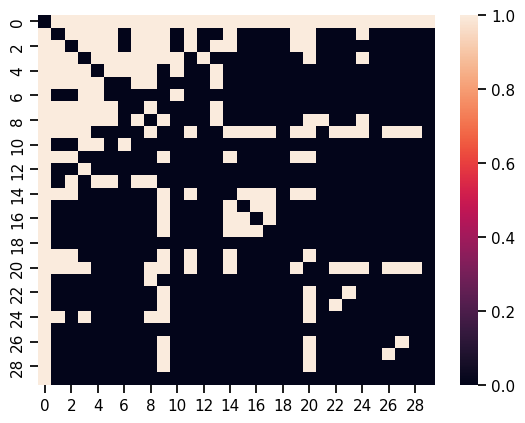

In [269]:
#We can also try a heatmap with seaborn
sns.heatmap(A)

This is a pretty sparse array, but it makes sense because every station most likely does not connect to hundreds of other stations. Observe how many of the connections (white squares) are clustered around the diagonal. This depends on how the data is sorted, but it would make sense in this case because a station is connected to the one directly before and after it. The graph is also symmetric because it is undirected. Also note that we still have not considered weight or layer data, so this is a top down view.

{}

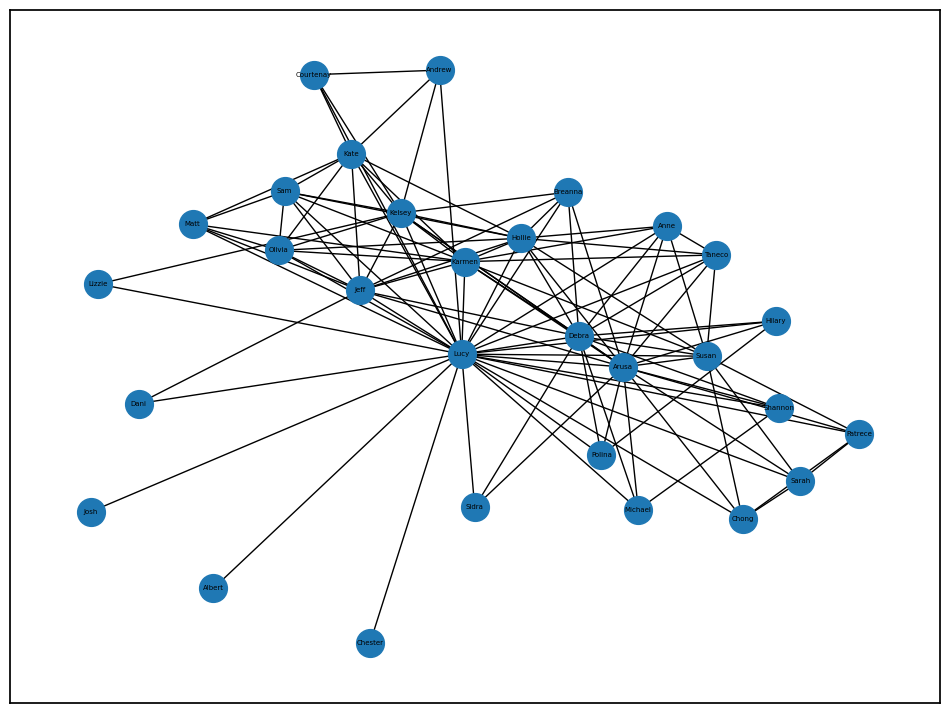

In [270]:
#Drawing the network

#This is pretty ugly, this helps with formatting so it looks less like a spider...
#I artificially scaled the figure size to try and make it as geographically close to the actual London transport network as possible
fig, ax = plt.subplots(1, 1, figsize=(12,9))

#Get generated position information so it is the same each time
pos=nx.spring_layout(G)

#Add weight labels
labels = nx.get_edge_attributes(G,'weight')

#Adding some more parameters to make it readable
nx.draw_networkx(G, pos, node_size=400, labels=node_dict, font_size=5, ax=ax)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)

## Node Attributes
We should consider some limitations that will make our data more interesting to interpret.

Since there are multiple layers to the train network, we should consider the layer number of each. We should also add in the weight, since it may help inform certain underground stations that are more densely connected than others. Lastly, we will add in the node names so we can reference which station is tied to which node.

In [277]:
#Set node attributes
nx.set_node_attributes(G, node_dict, 'station_name')
#nx.set_node_attributes(G, node_fare_dict, 'fare_zone')

#Set edge attributes
nx.set_edge_attributes(G, edge_weight, 'weight')
#nx.set_edge_attributes(G, edge_layer, 'layer')

Because our previous network excluded 11 edges since the same nodes were repeated, we need to make a multigraph if we want to preserve our edge data without it being overwritten.

In [278]:
#Multigraph fixes a lot of issues and we can include all 441 edges now
M = nx.MultiGraph()
M.add_nodes_from(t_nodes)
M.add_edges_from(edges)

#Add in attributes again but this time keyed to edge tuples with all 441 edges
#Set node attributes the same way as before
nx.set_node_attributes(M, node_dict, 'station_name')
#nx.set_node_attributes(M, node_fare_dict, 'fare_zone')

#Create edge attributes lists
edge_weight_M = []
#edge_layer_M = []
        
with open(r'/Users/lucywu/insight/teams_edges.csv', 'r') as insight_edge_csv:
    edge_reader = csv.reader(insight_edge_csv, delimiter=';')
    next(edge_reader, None)

    for row in edge_reader:
        if len(row) >= 3:  #check if the row has at least three elements
            edge_weight_M.append({'weight': int(row[2])})
        else:
            print(f"Error: Invalid row format in CSV. Skipping row: {row}")
        #edge_layer_M.append({'layer': int(row[3])})

#Make the dictionaries by joining the two lists
edge_weight_d = dict(zip(M.edges, edge_weight_M))
#edge_layer_d = dict(zip(M.edges, edge_layer_M))

#Set the multigraph edge attributes
nx.set_edge_attributes(M, edge_weight_d)
#nx.set_edge_attributes(M, edge_layer_d)

[[ 0. 55. 48. 35. 31. 28.  9.  4.  8.  9.  7.  6.  1.  3.  4.  1.  1.  1.
   1.  1.  5.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [55.  0. 37. 25. 20. 25.  0.  3.  2.  2.  0.  1.  0.  0.  2.  0.  0.  0.
   0.  1.  2.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [48. 37.  0. 24. 21. 24.  0.  4.  2.  1.  0.  1.  0.  1.  1.  0.  0.  0.
   0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [35. 25. 24.  0. 28. 21.  9.  1.  2.  1.  7.  0.  1.  0.  0.  0.  0.  0.
   0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [31. 20. 21. 28.  0. 19.  8.  2.  3.  0.  6.  0.  0.  3.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [28. 25. 24. 21. 19.  0.  0.  4.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 9.  0.  0.  9.  8.  0.  0.  0.  0.  0.  7.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 4.  3.  4.  1.  2.  4.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


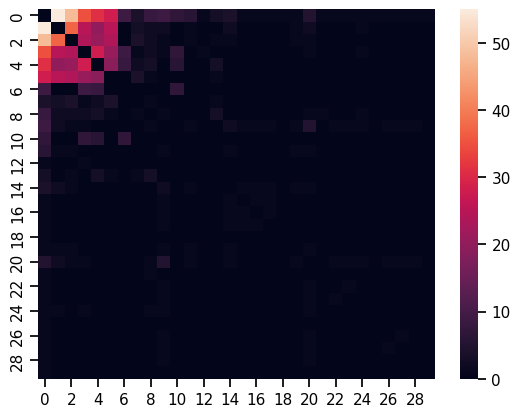

In [279]:
#Let's look at an array and heatmap of the multigraph instead
nodelist_M = list(M.nodes)
B = nx.to_numpy_array(M, nodelist=nodelist_M)

print(B)

sns.heatmap(B)

#Double check that the graph is symmetric
from graspologic.utils import is_symmetric
print(is_symmetric(B))

With multigraph: a white square means that an edge exists on multiple layers. It's fairly obvious that there are very few nodes that have edges which exist on multiple layers.

## Coloring the Nodes

In London, the fare system is based on which zone you travel from, and which zone you are travelling to. It is shaped similar to a bullseye or oyster (hence the Oyster Card payment system) so that the nexus is Zone 1 and the outskirts of London are Zone 9 and beyond. Interestingly, there are also half zones, so in that instance, I used .5 as a way to quantify these zones.

In [280]:
#Coloring by fare zone

'''
#Make a dataframe of fare zones
node_list = M.nodes
colors_dict = pd.DataFrame({
    'Index' : node_list,
    'Fare Zone' : node_fare
})

#Generate colors based on the number of unique fare zones
#I chose the 'hls' system because it provided the most contrast and thus made the zones the most visible
colors = sns.color_palette('hls', colors_dict['Fare Zone'].nunique())
#Make a color palette dictionary
palette = dict(zip(sorted(colors_dict['Fare Zone'].unique()), colors))
#Map colors to node and update the color attribute
colors_dict['color'] = colors_dict['Fare Zone'].map(palette)

#Output a color palette
sns.set_context('notebook')
sns.palplot(sns.color_palette("hls", colors_dict['Fare Zone'].nunique()))
plt.show()

#Same plotting attributes as before
fig, ax = plt.subplots(1, 1, figsize=(20,12))

#Same plot just now with our colors!
#Using the kamada kawai layout system
pos = nx.kamada_kawai_layout(M)
nx.draw_networkx(M, pos=pos, node_size=25, node_color=colors_dict['color'], labels=node_dict, font_size=5, ax=ax)
'''

'\n#Make a dataframe of fare zones\nnode_list = M.nodes\ncolors_dict = pd.DataFrame({\n    \'Index\' : node_list,\n    \'Fare Zone\' : node_fare\n})\n\n#Generate colors based on the number of unique fare zones\n#I chose the \'hls\' system because it provided the most contrast and thus made the zones the most visible\ncolors = sns.color_palette(\'hls\', colors_dict[\'Fare Zone\'].nunique())\n#Make a color palette dictionary\npalette = dict(zip(sorted(colors_dict[\'Fare Zone\'].unique()), colors))\n#Map colors to node and update the color attribute\ncolors_dict[\'color\'] = colors_dict[\'Fare Zone\'].map(palette)\n\n#Output a color palette\nsns.set_context(\'notebook\')\nsns.palplot(sns.color_palette("hls", colors_dict[\'Fare Zone\'].nunique()))\nplt.show()\n\n#Same plotting attributes as before\nfig, ax = plt.subplots(1, 1, figsize=(20,12))\n\n#Same plot just now with our colors!\n#Using the kamada kawai layout system\npos = nx.kamada_kawai_layout(M)\nnx.draw_networkx(M, pos=pos, node_s

I would have expected that the red zone (Fare Zone 1) would be centralized and most connected, which appeares to be visually accurate here. However, The most interesting line to me is the yellow branch because it belongs to Fare Zone 2, yet is not as connected to other zones as you would expect for an inner zone. Other branches are very colorful, indicating that as you travel further down the branch, you travel through other zones compared to the yellow which only passes through one.

{(0, 1): Text(-0.989073783159256, -0.10395593842002171, '55'),
 (0, 3): Text(-0.9045084714889526, -0.2938927253100516, '35'),
 (0, 4): Text(-0.8345652520656586, -0.37157247861357945, '31'),
 (0, 5): Text(-0.7499999552965164, -0.4330127676341178, '28'),
 (0, 2): Text(-0.9567727148532867, -0.2033684094760062, '48'),
 (0, 6): Text(-0.6545085459947586, -0.4755282839152457, '9'),
 (0, 7): Text(-0.5522641688585281, -0.4972610016677024, '4'),
 (0, 9): Text(-0.3454914391040802, -0.4755282839152457, '9'),
 (0, 8): Text(-0.44773558154702187, -0.49726097186538, '8'),
 (0, 13): Text(-0.04322722554206848, -0.20336829026671666, '3'),
 (0, 10): Text(-0.2500000447034836, -0.4330127676341178, '7'),
 (0, 11): Text(-0.16543462872505188, -0.3715724190089347, '6'),
 (0, 12): Text(-0.09549137949943542, -0.2938925166937949, '1'),
 (0, 29): Text(-0.9890738129615784, 0.1039556796338914, '1'),
 (0, 14): Text(-0.010926216840744019, -0.10395592351886052, '4'),
 (0, 15): Text(0.0, 4.371138828673793e-08, '1'),
 (0,

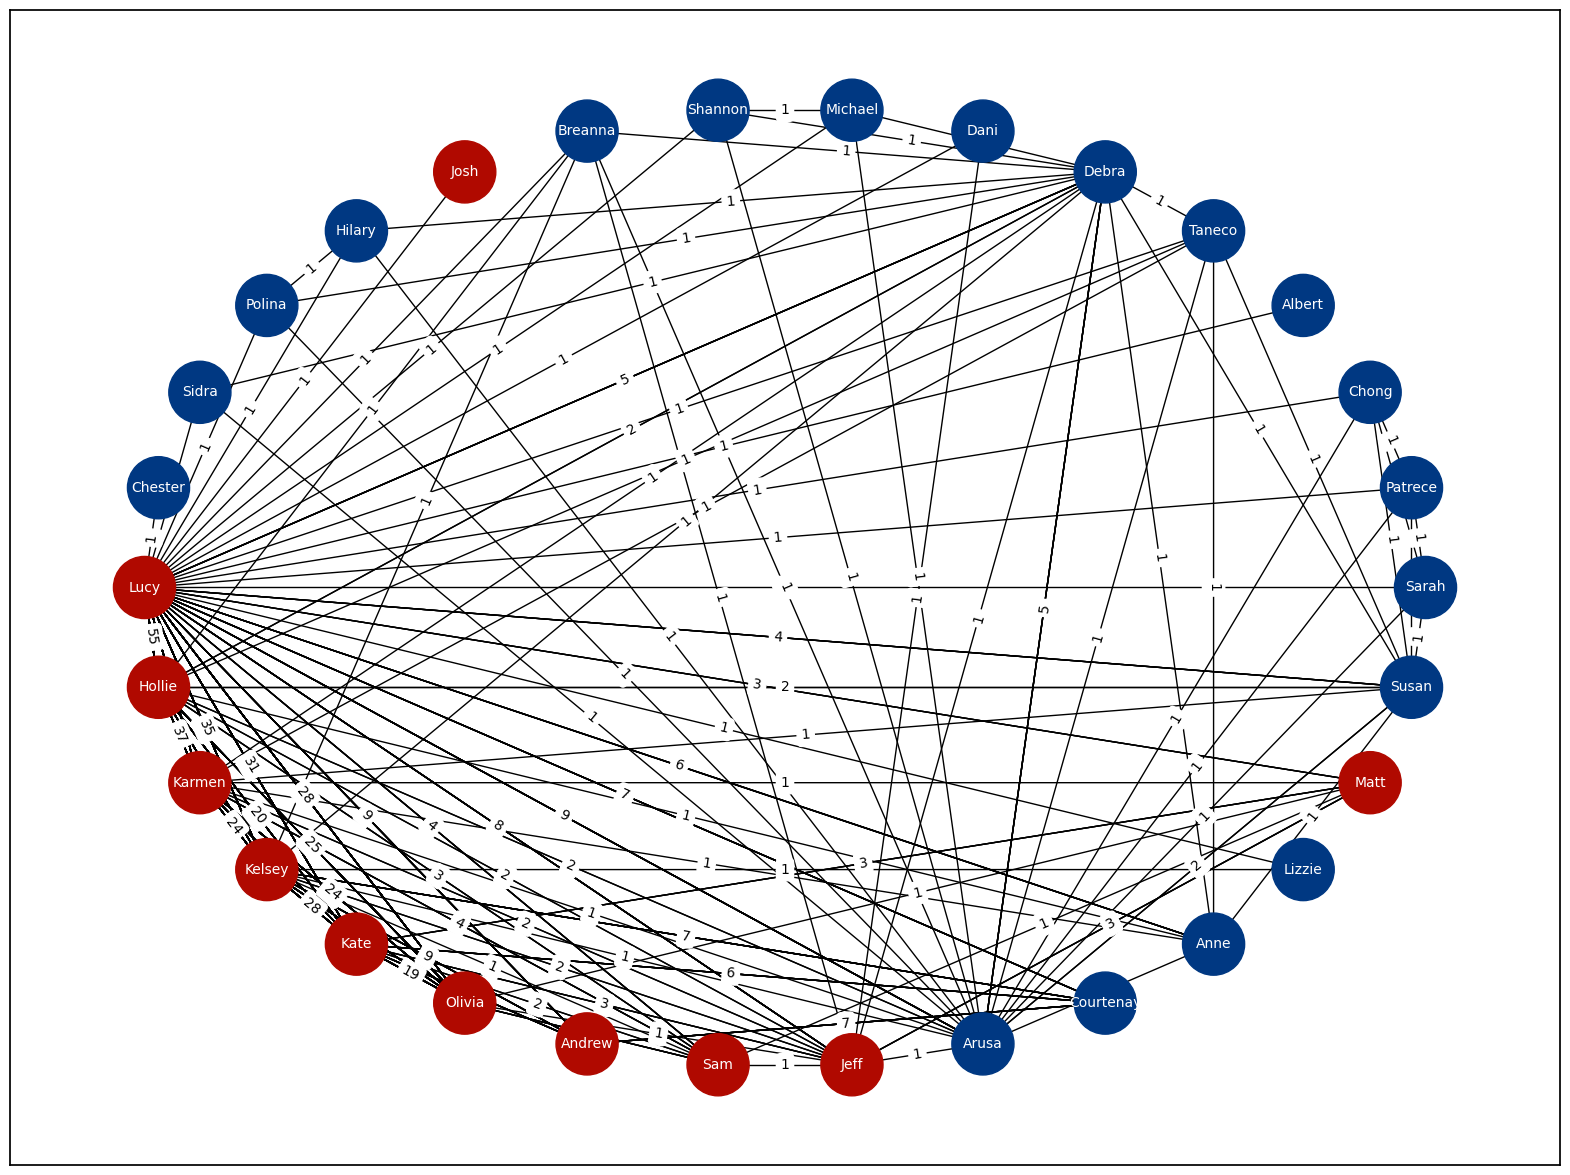

In [389]:
from collections import Counter
c = Counter(M.edges())

for u, v, d in M.edges(data=True):
    d['weight'] = c[u, v]

fig, ax = plt.subplots(1, 1, figsize=(20,15))

pos = nx.shell_layout(M)

#Make a dictionary of edge weights
edge_weights = {(u, v): d['weight'] for u, v, d in M.edges(data=True)}

#Team colors to differentiate
team = ['#b00900', '#b00900', '#b00900', '#b00900', '#b00900', '#b00900', '#b00900', '#b00900', '#b00900', '#003882', '#003882', '#003882', '#003882', '#b00900', '#003882', '#003882', '#003882', '#003882', '#003882', '#003882', '#003882', '#003882', '#003882', '#003882', '#003882', '#b00900', '#003882', '#003882', '#003882', '#003882']

#Using our new node positions instead
nx.draw_networkx(M, pos, node_size=2000, labels=node_dict, font_size=10, ax=ax, node_color=team, font_color=(1,1,1,1))
#Can use: width=[d['weight'] for _, _, d in M.edges(data=True)] for the weight if desired
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels = edge_weights)

While this is more geographically accurate, there is some information lost or not translated as well since you can't see the isolated branch of yellow as clearly. However, you can see how each zone blends into the next and forms rings.

## Network Connectedness

In [390]:
#Connectedness: the whole thing should be connected
print(nx.is_connected(M))

#Returns true, so we know the whole network is connected
#Since it is an undirected network, we don't need to test for weak or strong connectedness

from graspologic.utils import largest_connected_component

M_lcc = largest_connected_component(M)
print(M_lcc)
#Quick check: since the entire network is connected, the largest connected component is shown to be the entire network

True
MultiGraph with 30 nodes and 642 edges


## Network Degrees
Since we are using an undirected network, degrees are simply a count of all the edges connected to each node (we don't need to worry about in or out degrees). In our case, it tells us how many other stations are connected to each station.

In [391]:
#Degrees of our network

#Function to help compare the dictionaries with outputs of the array
def map_to_nodes(node_map):
    node_map.setdefault(0)
    return np.array(np.vectorize(lambda x: node_map.setdefault(x, 0))(M.nodes))

#Note: If nodes are connected on multiple layers, this is also counted as well
degrees = dict((M.degree))

#map_to_nodes(degrees)

TypeError: cannot unpack non-iterable int object

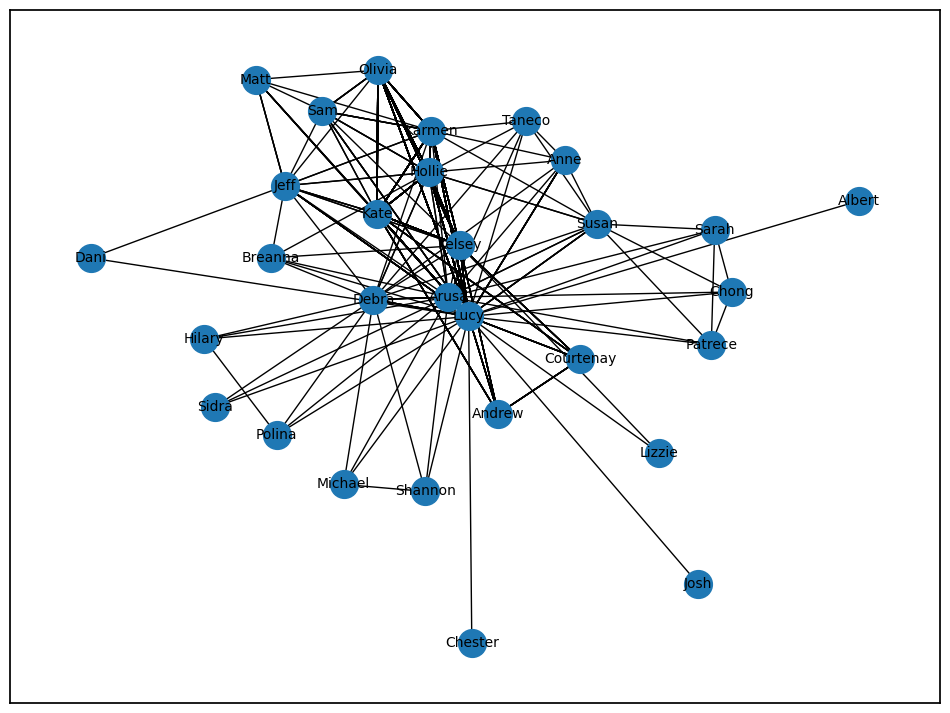

In [392]:
#Plotting now with degrees

pos=nx.spring_layout(G)

fig, ax = plt.subplots(1, 1, figsize=(12,9))

#Using our new node positions instead
nx.draw_networkx(M, pos, node_size=400, labels=node_dict, font_size=10, ax=ax)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=degrees)



#Add weight labels
#labels = nx.get_edge_attributes(G,'weight')

#Adding some more parameters to make it readable
#nx.draw_networkx(G, pos, node_size=400, labels=node_dict, font_size=5, ax=ax)


In [393]:


#Add weight labels
#labels = nx.get_edge_attributes(G,'weight')

#Adding some more parameters to make it readable
#nx.draw_networkx(G, pos, node_size=400, labels=node_dict, font_size=5, ax=ax)


From our array, we can see a few things:
1. If the degree is 1, that signifies the end of the line or branch
2. If the degree is 2, it is contributing to an inner station of a line or branch
3. Anything more shows it is interconnected with other stations

Next, I wanted to look at the stations with the highest raw number of degree connections.

In [394]:
#This provides a sorted list of degree connections
#Borrowed from https://stackoverflow.com/questions/48382575/sort-graph-nodes-according-to-their-degree
max_degrees = sorted(M.degree, key=lambda x: x[1], reverse=True)
#I included the first 12, which includes all of the stations with both 7 and 6 connections
print(max_degrees[0:12])

[(0, 267), (1, 176), (2, 166), (3, 156), (4, 141), (5, 123), (6, 33), (9, 32), (10, 27), (8, 26), (20, 24), (7, 20)]


Top 12 Stations by Degree\
7 Connections
1. Willesden Junction (2.5)
2. Baker Street (1)
3. Kings Cross St. Pancras (1)
4. Stratford (2.5)

6 Connections

5. Westham (2.5)
6. Bank (1)
7. Earls Court (1.5)
8. Paddington (1)
9. Green Park (1)
10. Oxford Circus (1)
11. Canning Town (2.5)
12. Waterloo (1)

It makes sense that the top stations would belong to zones 1 to 2.5. Interestingly enough, there are no Zone 2 stations in this list, while there are a good portion of Zone 2.5 stations. This might suggest Zone 2.5 is more interconnected or important in a sense than Zone 2. Additionally, this pairs well with our findings from the colored graph previously, where Zone 2 actually had a more isolated branch in comparison. This may have contributed to its low number of degrees or connections.

## Plotting Centrality Measures (Multigraph Attempt)

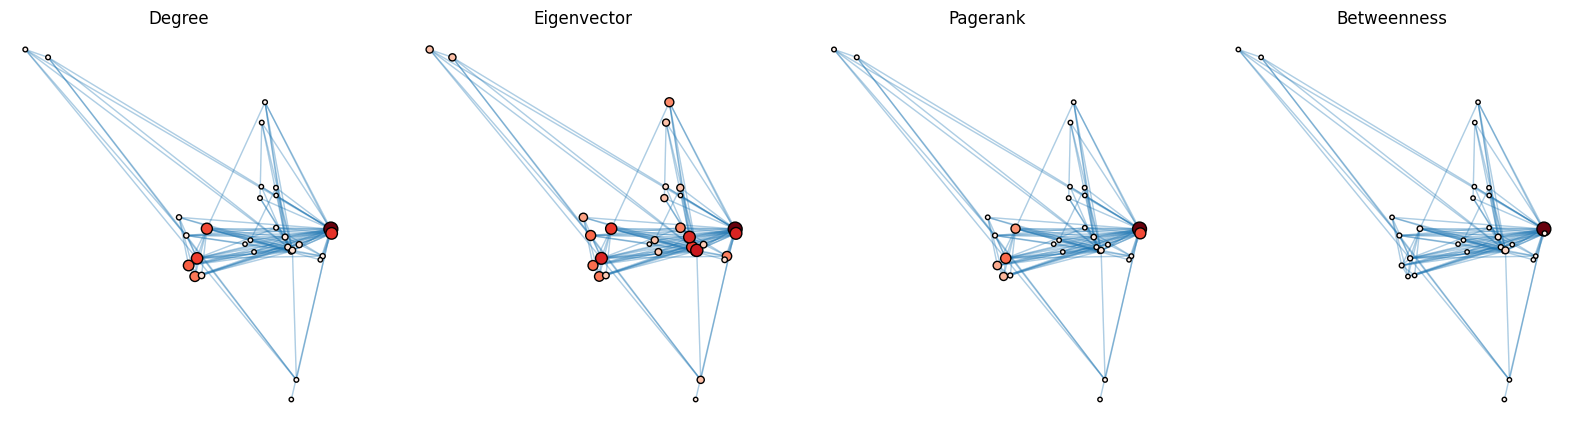

In [395]:
#Plotting and comparing different connectedness measures

from graspologic.plot import networkplot
from matplotlib import colors

multi_data = pd.DataFrame(index=M.nodes())
#Adjusting the x and y to be longitude and latitude
multi_data['x'] = multi_data.index.map(node_data[' nodeLong'])
multi_data['y'] = multi_data.index.map(node_data[' nodeLat'])
multi_data["degree"] = multi_data.index.map(dict(nx.degree(M)))
multi_data["eigenvector"] = multi_data.index.map(nx.eigenvector_centrality(G, weight = 'weight'))
multi_data["pagerank"] = multi_data.index.map(nx.pagerank(M))
multi_data["betweenness"] = multi_data.index.map(nx.betweenness_centrality(M))

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

def plot_node_scaled_network(A, node_data, key, ax):
    # REF: https://github.com/mwaskom/seaborn/blob/9425588d3498755abd93960df4ab05ec1a8de3ef/seaborn/_core.py#L215

    levels = list(np.sort(node_data[key].unique()))
    #Changed color palette for more contrast
    cmap = sns.color_palette('Reds', as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.3 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    networkplot(
        A,
        node_data=node_data,
        x='x',
        y='y',
        ax=ax,
        edge_linewidth=1.0,
        node_size=key,
        node_hue=key,
        palette=palette,
        #Scaled down node sizes by a factor of 2 so it's less clumped
        node_sizes=(10, 100),
        node_kws=dict(linewidth=1, edgecolor="black"),
        node_alpha=1.0,
        edge_kws=dict(color=sns.color_palette()[0])
    )
    ax.axis("off")
    ax.set_title(key.capitalize())

ax = axs[0]
plot_node_scaled_network(A, multi_data, "degree", ax)
ax = axs[1]
plot_node_scaled_network(A, multi_data, "eigenvector", ax)
ax = axs[2]
plot_node_scaled_network(A, multi_data, "pagerank", ax)
ax = axs[3]
plot_node_scaled_network(A, multi_data, "betweenness", ax)
fig.set_facecolor("w")

In [396]:
#View tabular node centrality measure data
#Reverse sort to view the properties of nodes with the highest degree 
print(multi_data.sort_values(by='degree', ascending=False))

           x          y  degree  eigenvector  pagerank  betweenness
0   0.003738  51.531952     267     0.401139  0.260069     0.546552
1   0.005332  51.528526     176     0.286257  0.152252     0.017406
2  -0.263416  51.508758     166     0.284125  0.130825     0.019458
3  -0.243895  51.532234     156     0.258318  0.097351     0.034360
4  -0.280288  51.503071     141     0.201386  0.079062     0.011494
5  -0.267723  51.494371     123     0.186487  0.069604     0.000821
6  -0.254510  51.495182      33     0.087877  0.012506     0.000000
9  -0.072987  51.515082      32     0.305871  0.028435     0.086494
10 -0.059406  51.519588      27     0.087877  0.009998     0.000000
8  -0.082235  51.517598      26     0.255290  0.012271     0.021223
20 -0.087609  51.525581      24     0.279460  0.020041     0.044622
7  -0.075613  51.514342      20     0.186487  0.006670     0.000821
14 -0.284915  51.526834      15     0.206409  0.011681     0.012315
11 -0.012610  51.510477      12     0.179998  0.

/Users/lucywu/insight/insight_network_venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


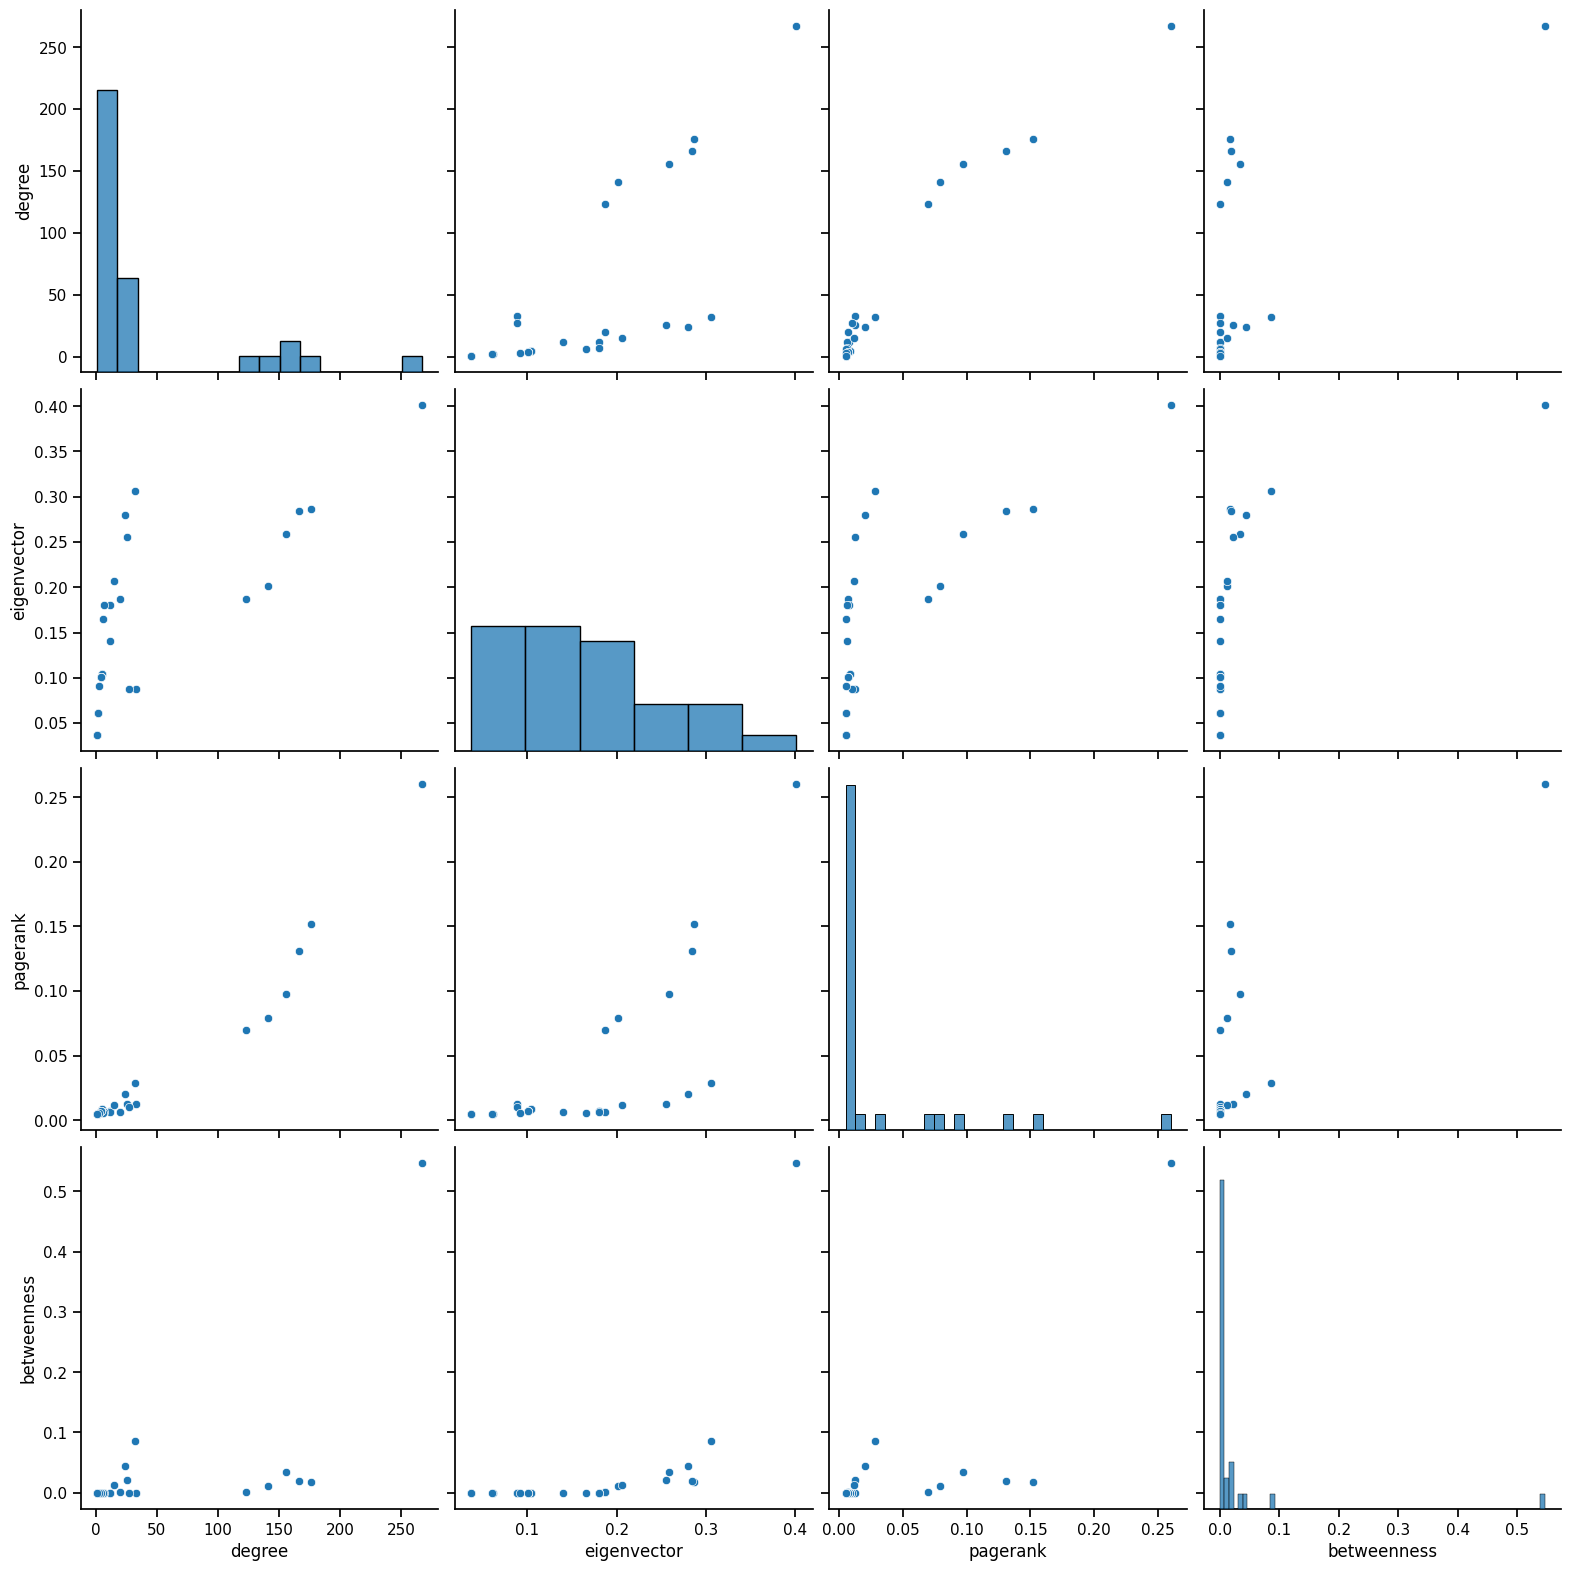

In [397]:
#See the correlation between each degree measure
sns.pairplot(multi_data, vars=['degree', 'eigenvector', 'pagerank', 'betweenness'], height=4)

It was at this point that I realized it would not be effective to use a multigraph network in combination with eigenvector centrality measures, since we are not sure what it assumes about our data. Also, eigenvector centrality would not run with a multigraph network, so I had to use my original network with some weighting parameters, but inherently makes the graphs unequal because they are using slightly different networks. Later, I will fix this by using a simpler network and compressing some of our data to ensure at least we know what the centrality measures are doing to our data, so we have a more accurate interpretation.

## Community Detection
How can we divide our train network into communities that make sense?\
We will use the Leiden algorithm.

(<Figure size 1500x700 with 4 Axes>, <Axes: title={'center': 'Betweenness'}>)

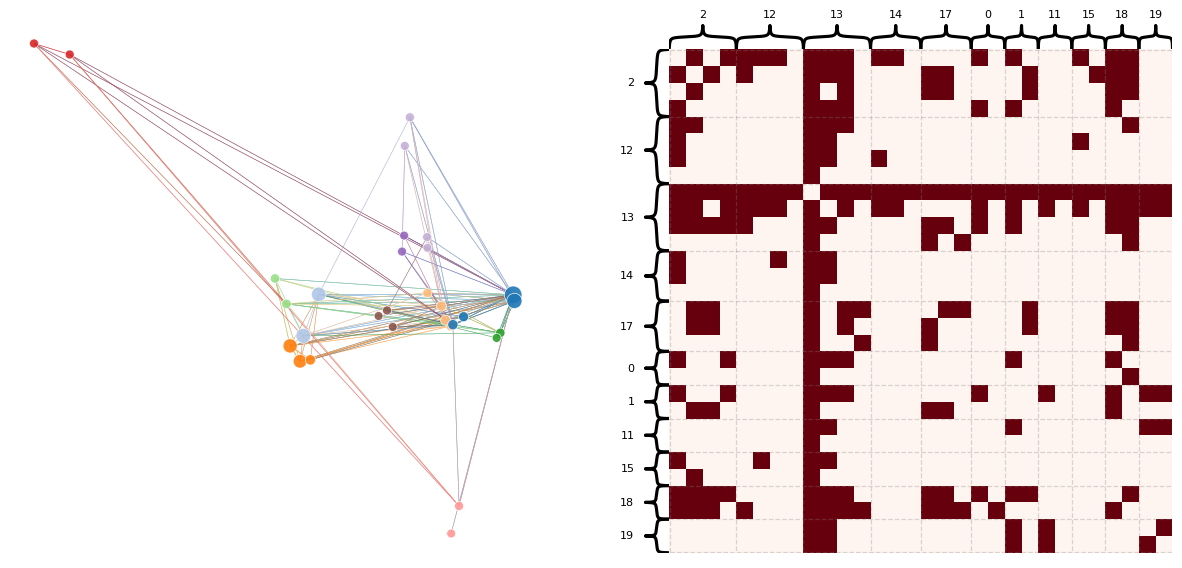

In [398]:
#Plotting our community partitions generated with Leiden
#Credit to: https://bdpedigo.github.io/networks-course/community_detection.html#agglomerative-optimization-louvain-leiden
def plot_network_partition(adj, node_data, partition_key):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    networkplot(
        adj,
        x='x',
        y='y',
        node_data=node_data.reset_index(),
        node_alpha=0.9,
        edge_alpha=0.7,
        edge_linewidth=0.4,
        node_hue=partition_key,
        node_size="degree",
        edge_hue="source",
        ax=axs[0],
        #tab20 to prevent more communities than colors
        palette='tab20'
    )
    axs[0].axis("off")

    heatmap(
        adj,
        inner_hier_labels=node_data[partition_key],
        ax=axs[1],
        cbar=False,
        cmap="Reds",
        vmin=0,
        center=None,
        sort_nodes=True,
        hier_label_fontsize=8
    )

    return fig, ax

#Use our original multi_data pandas dataframe
multi_data['leiden_partition'] = multi_data.index.map(leiden_partition_map)
#Use our original unweighted adjacency matrix A
plot_network_partition(A, multi_data, 'leiden_partition')

From this Leiden graph, the algorithm seems to have created communities related to the branches, or more specifically, the lines of our train network. This would make sense because communities would be likely to form where there are connections with each other, and that's exactly where some lines are located. Considering fare zone, this makes the center of the graph interesting since there are multiple intersecting lines passing through Zone 1.

## Plotting Centrality Measures (Weighted Graph)
'Weight' now means if a station has a non-1 weight, it connects a station to another station on either multiple layers and/or it has an underground connection with multiple lines. More simply, it is the sum of all of the weights connecting to or from that particular node.

In [399]:
#Weighted Graph: A more aggregate view
#Constructed from our mulitgraph data

W = nx.Graph()
for u,v,data in M.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if W.has_edge(u,v):
        W[u][v]['weight'] += w
    else:
        W.add_edge(u, v, weight=w)

This looks a bit different than what we saw earlier, because now we are including the weights in each one which inflates our degree count technically. For instance, 181 (King's Cross St Pancras) has a degree of 12, which is much larger than the degree of 7 it had before.

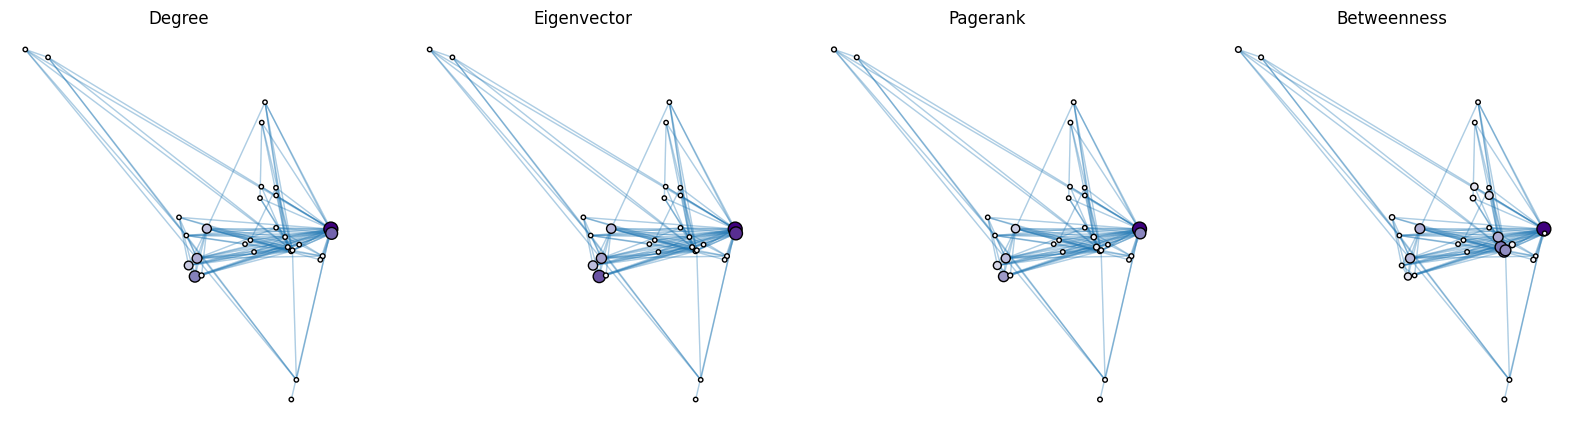

In [400]:
import pandas as pd

weighted_data = pd.DataFrame(index=W.nodes())
#Adjust the x and y again to account for our long and lat
weighted_data['x'] = multi_data.index.map(node_data[' nodeLong'])
weighted_data['y'] = multi_data.index.map(node_data[' nodeLat'])
weighted_data["degree"] = weighted_data.index.map(dict(nx.degree(W, weight = 'weight')))
weighted_data["eigenvector"] = weighted_data.index.map(nx.eigenvector_centrality(W, weight='weight'))
weighted_data["pagerank"] = weighted_data.index.map(nx.pagerank(W, weight='weight'))
#Weight correlates to distance? Not sure if that is right
weighted_data["betweenness"] = weighted_data.index.map(nx.betweenness_centrality(W, weight='weight'))

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

def plot_node_scaled_network(A, node_data, key, ax):
    # REF: https://github.com/mwaskom/seaborn/blob/9425588d3498755abd93960df4ab05ec1a8de3ef/seaborn/_core.py#L215

    levels = list(np.sort(node_data[key].unique()))
    #Changed color palette for more contrast
    cmap = sns.color_palette('Purples', as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.3 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    networkplot(
        A,
        node_data=node_data,
        x="x",
        y="y",
        ax=ax,
        edge_linewidth=1.0,
        node_size=key,
        node_hue=key,
        palette=palette,
        #Scaled down node sizes by a factor of 2 so it's less clumped
        node_sizes=(10, 100),
        node_kws=dict(linewidth=1, edgecolor="black"),
        node_alpha=1.0,
        edge_kws=dict(color=sns.color_palette()[0])
    )
    ax.axis("off")
    ax.set_title(key.capitalize())

ax = axs[0]
plot_node_scaled_network(A, weighted_data, "degree", ax)
ax = axs[1]
plot_node_scaled_network(A, weighted_data, "eigenvector", ax)
ax = axs[2]
plot_node_scaled_network(A, weighted_data, "pagerank", ax)
ax = axs[3]
plot_node_scaled_network(A, weighted_data, "betweenness", ax)
fig.set_facecolor("w")

/Users/lucywu/insight/insight_network_venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


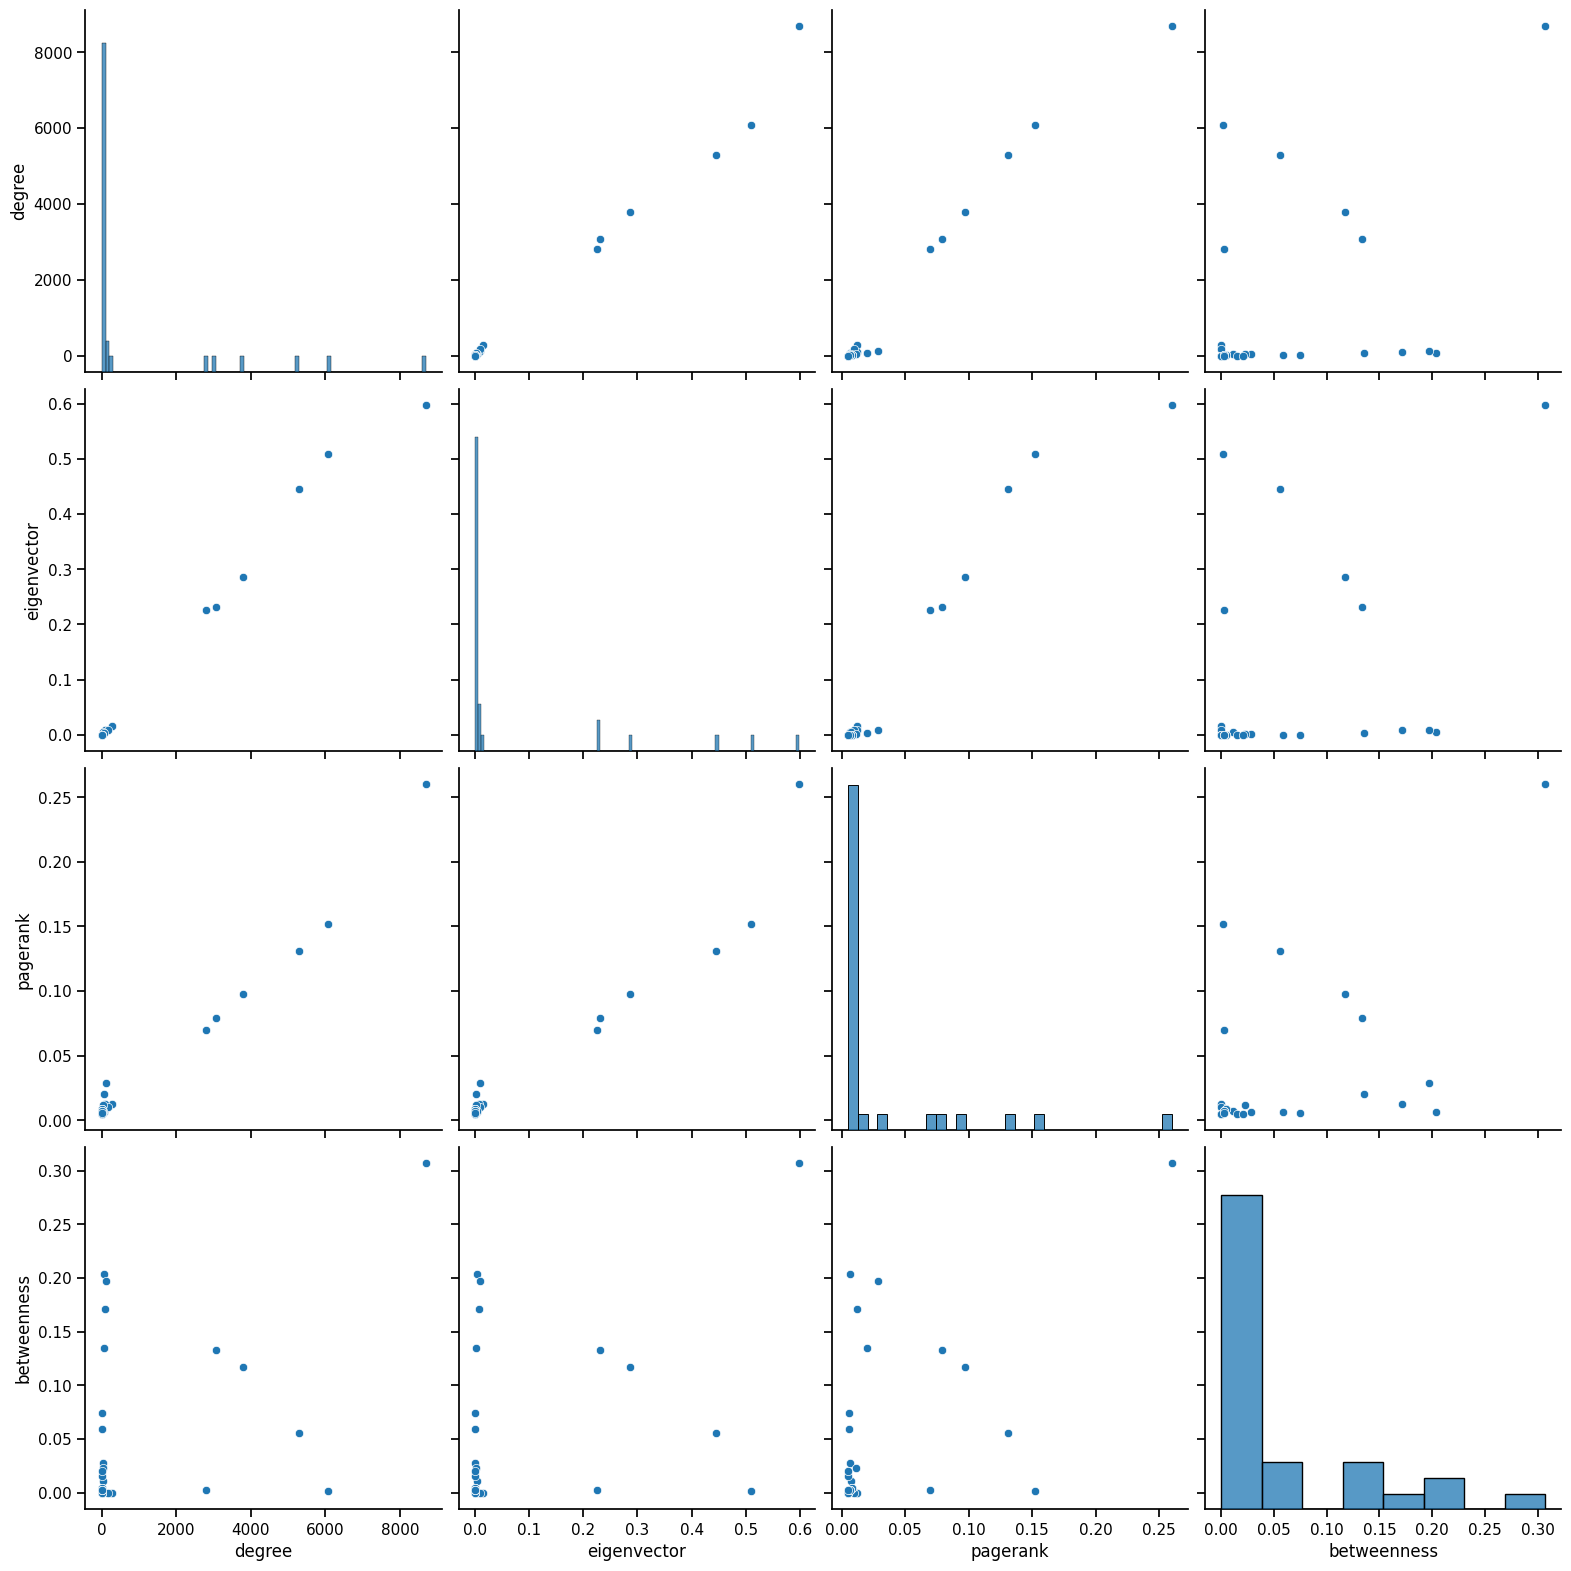

In [401]:
sns.pairplot(weighted_data, vars=['degree', 'eigenvector', 'pagerank', 'betweenness'], height=4)

What is happening here?

Degree: Very discrete because degree only ranges from 1 to 12, which is why there are vertical lines. There is some positive correlation between degree and pagerank, indicating that in general, stations that have more links to other stations will have a greater importance, which is expected.

Betweenness: There is also some weak relation with pagerank. With a low betweenness score or influence on travel in the network, most nodes tend to have a low pagerank, and that would make sense considering most nodes only connect to two other stations, before and after them in the line. Thus, they would not have a large pagerank since the node would have low importance. It is interesting how the pagerank varies as betweenness increases, indicating that some nodes that connect multiple stations and affect travel, are not as important as others.

## Comparing Stations
Now, let's compare stations based on their centrality measure values.

In [402]:
d = weighted_data.sort_values(by='degree', ascending=False)
e = weighted_data.sort_values(by='eigenvector', ascending=False)
p = weighted_data.sort_values(by='pagerank', ascending=False)
b = weighted_data.sort_values(by='betweenness', ascending=False)

#Print out the 20 nodes with the highest degrees and eigenvectors
print(d.iloc[0:10,2])
print(e.iloc[0:10,3])

0     8691
1     6072
2     5292
3     3790
4     3069
5     2805
6      275
10     183
9      128
8      100
Name: degree, dtype: int64
0     0.597244
1     0.509146
2     0.444683
3     0.285952
4     0.230624
5     0.225456
6     0.015623
10    0.009426
9     0.009228
8     0.008196
Name: eigenvector, dtype: float64


In [403]:
#Print out the 20 nodes with the highest pagerank and betweenness
print(p.iloc[0:10,4])
print(b.iloc[0:10,5])

0     0.260069
1     0.152252
2     0.130825
3     0.097351
4     0.079062
5     0.069604
9     0.028435
20    0.020041
6     0.012506
8     0.012271
Name: pagerank, dtype: float64
0     0.306838
7     0.203618
9     0.197217
8     0.171301
20    0.135101
4     0.133005
3     0.117172
24    0.074377
19    0.059006
2     0.056053
Name: betweenness, dtype: float64


In [404]:
rankings = {'rank': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
'degree': ['Kings Cross (1)', 'Baker Street (1)', 'Westham (2.5)', 'Liverpool Street (1)', 'Moorgate (1)', 'Embankment (1)', 'Willesden Junction (2.5)', 'Stratford (2.5)', 'Earls Court (1.5)', 'Waterloo (1)'], 
'eigenvec': ['Kings Cross (1)', 'Farringdon (1)', 'Euston Square (1)', 'Barbican (1)', 'Great Portland Street (1)', 'Moor Gate (1)', 'Euston (1)', 'Baker Street (1)', 'Liverpool Street (1)', 'Angel (1)'], 
'pagerank': ['Kings Cross (1)', 'Baker Street (1)', 'Stratford (2.5)', 'Westham (2.5)', 'Canning Town (2.5)', 'Paddington (1)', 'Willesden Junction (2.5)', 'Euston (1)', 'Earls Court (1.5)', 'Liverpool Street (1)'], 
'betweenness': ['Bank (1)', 'Greenpark (1)', 'Bondstreet (1)', 'Waterloo (1)', 'Baker Street (1)', 'Finchley Road (2)', 'Westminster (1)', 'Stratford (2.5)', 'Willesden Junction (2.5)', 'Canada Water (2)'],
'foot traffic': ['Kings Cross (1)', 'Victoria (1)', 'Oxford Circus (1)', 'London Bridge (1)', 'Waterloo (1)', 'Stratford (2.5)', 'Liverpool Street (1)', 'Paddington (1)', 'Canary Wharf (2)', 'Bank (1)']
}
pd.DataFrame(data = rankings)

,rank,degree,eigenvec,pagerank,betweenness,foot traffic
0,1,Kings Cross (1),Kings Cross (1),Kings Cross (1),Bank (1),Kings Cross (1)
1,2,Baker Street (1),Farringdon (1),Baker Street (1),Greenpark (1),Victoria (1)
2,3,Westham (2.5),Euston Square (1),Stratford (2.5),Bondstreet (1),Oxford Circus (1)
3,4,Liverpool Street (1),Barbican (1),Westham (2.5),Waterloo (1),London Bridge (1)
4,5,Moorgate (1),Great Portland Street (1),Canning Town (2.5),Baker Street (1),Waterloo (1)
5,6,Embankment (1),Moor Gate (1),Paddington (1),Finchley Road (2),Stratford (2.5)
6,7,Willesden Junction (2.5),Euston (1),Willesden Junction (2.5),Westminster (1),Liverpool Street (1)
7,8,Stratford (2.5),Baker Street (1),Euston (1),Stratford (2.5),Paddington (1)
8,9,Earls Court (1.5),Liverpool Street (1),Earls Court (1.5),Willesden Junction (2.5),Canary Wharf (2)
9,10,Waterloo (1),Angel (1),Liverpool Street (1),Canada Water (2),Bank (1)


Note: I included the top 10 busiest stations based on foot traffic data from https://en.wikipedia.org/wiki/List_of_busiest_London_Underground_stations as a comparison metric. Most stations on the foot traffic list make an appearance in our centrality lists, however a few don't, namely, Victoria, Oxford Circus, London Bridge, and Canary Wharf. This suggests there might be another factor that isn't based on the connectedness or node importance that causes this discrepency.